# FoldX treshold for training set
The purpose of this notebook is to calculate the treshold and accuracy of the FoldX

#### Dependencies

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [209]:
df=pd.read_csv('foldx_training_set_analyse.txt',delimiter='\t')
df_actual=pd.read_excel("training_set_pathogenicity.xlsx")

In [210]:
df_actual=pd.concat([df_actual['#Coordinate'].rename('Coor'),df_actual['Pathogenicity'].rename('actual_Pathogenicity')],axis=1)

In [211]:
frames=pd.merge(df, df_actual, how='inner', on='Coor')

frames.loc[(frames.actual_Pathogenicity=='Likely_benign'),'actual_Pathogenicity']= 'Benign'
frames.loc[(frames.actual_Pathogenicity=='Likely_pathogenic'),'actual_Pathogenicity']= 'Pathogenic'

In [212]:
frames.head(5)

,Coor,deltaG,actual_Pathogenicity
0,chr13:g.32363456:A>T,13.55,Benign
1,chr17:g.43045739:A>C,14.46,Benign
2,chr17:g.43045739:A>C,15.22,Benign
3,chr17:g.43063337:T>A,5.05,Benign
4,chr17:g.43063337:T>A,2.59,Benign


In [213]:
max_change=frames['deltaG'].max()
frames.deltaG=frames['deltaG']/max_change
frames.head(5)


,Coor,deltaG,actual_Pathogenicity
0,chr13:g.32363456:A>T,0.258046,Benign
1,chr17:g.43045739:A>C,0.275376,Benign
2,chr17:g.43045739:A>C,0.289850,Benign
3,chr17:g.43063337:T>A,0.096172,Benign
4,chr17:g.43063337:T>A,0.049324,Benign


In [214]:
fpr, tpr, thr = roc_curve(frames.actual_Pathogenicity,frames.deltaG, pos_label='Pathogenic')

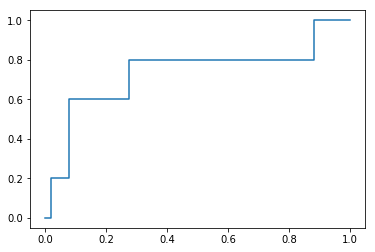

<Figure size 432x288 with 0 Axes>

In [215]:
plt.plot(fpr, tpr)
# plt.xlabel("Vest P-value")

plt.show()
plt.savefig("foldx training roc.pdf")

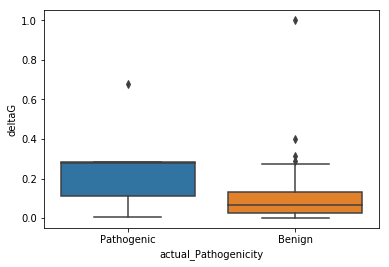

In [216]:
sns.boxplot(x='actual_Pathogenicity',y='deltaG',data=frames,order=["Pathogenic", "Benign"])


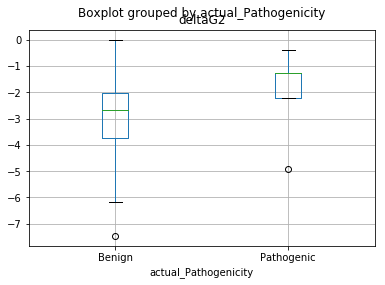

In [217]:
frames['deltaG2'] = np.log(frames['deltaG'])
frames.boxplot(column='deltaG2' ,by='actual_Pathogenicity', )

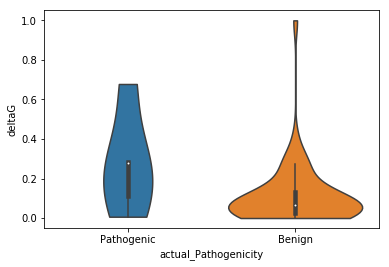

In [218]:
sns.violinplot(x='actual_Pathogenicity',y='deltaG',data=frames,order=["Pathogenic", "Benign"],cut=0)

In [219]:
acum, tp, total, accuracy,pval=0,0,0,0,0
acum_acc,acum_pval,tn_lis,tp_lis,fp_lis,fn_lis=[],[],[],[],[],[]

In [220]:
for i in np.arange(0.05,1.,0.0001):
    i=round(i,4)
    frames.loc[(frames.deltaG<=i), 'Predicted']= 'Pathogenic'
    frames.loc[(frames.deltaG>i), 'Predicted']= 'Benign'
    frames

    tn=len(frames.loc[(frames.Predicted.astype(str)=='Benign')&(frames.actual_Pathogenicity.astype(str)=='Benign')])+0.0
    tp=len(frames.loc[(frames.Predicted.astype(str)=='Pathogenic')&(frames.actual_Pathogenicity.astype(str)=='Pathogenic')])+0.0

    fn=len(frames.loc[(frames.Predicted.astype(str)=='Benign')&(frames.actual_Pathogenicity.astype(str)=='Pathogenic')])+0.0
    fp=len(frames.loc[(frames.Predicted.astype(str)=='Pathogenic')&(frames.actual_Pathogenicity.astype(str)=='Benign')])+0.0
    t=tn+tp
    f=(fn+fp)
    total=t+f
    accuracy=((t/(total)*1.0)*1.0)
    
    tn_lis.append(tn)
    tp_lis.append(tp)
    fn_lis.append(fn)
    fp_lis.append(fp)
    
    acum_acc.append(accuracy)
    acum_pval.append(i)
    
    if(acum<accuracy):
        acum=accuracy
        pval=i
        

In [221]:
pval=round(pval,2)
print(pval)
acum=round(acum,2)
print ("accuracy "+str(acum))

0.05
accuracy 0.57


# TEST DATA

In [222]:
df2_test=pd.read_csv('foldx_test_set_analyse.txt',delimiter='\t')
df_actual_test=pd.read_csv("test_set.csv")


In [223]:
frames2=pd.merge(df2_test, df_actual_test, how='inner', on='GenomicCoordinate')


In [224]:
max_change=frames2['deltaG'].max()
frames2.deltaG=frames2['deltaG']/max_change
frames2.head(5)


,GenomicCoordinate,deltaG,Pathogenicity
0,chr13:g.32362692:A>G,0.390531,Pathogenic
1,chr17:g.43057113:T>A,0.058045,Pathogenic
2,chr17:g.43057113:T>A,0.162525,Pathogenic
3,chr17:g.43106457:T>C,0.008163,Pathogenic
4,chr17:g.43057116:C>T,0.551061,Pathogenic


## ROC Curve

In [225]:
fpr, tpr, thr = roc_curve(frames2.Pathogenicity,frames2.deltaG, pos_label='Pathogenic')

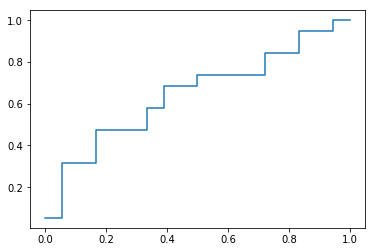

<Figure size 432x288 with 0 Axes>

In [226]:
plt.plot(fpr, tpr)
plt.show()
plt.savefig("foldx test roc.pdf")

### Box Plot

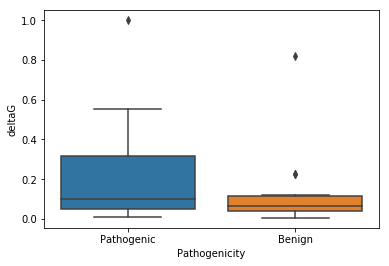

In [227]:
sns.boxplot(x='Pathogenicity',y='deltaG',data=frames2,order=["Pathogenic", "Benign"])

### Area Under curve

In [228]:
y_true = np.ones(len(frames2.Pathogenicity))
y_true[frames2.Pathogenicity == 'Benign'] = 0
roc_auc_score(y_true,frames2.deltaG)

0.6432748538011697

### Use Treshold that was calculated in Training

In [229]:
temp = list('B'*len(frames2))
frames2.insert(2, column='Predicted', value=temp)
frames2.loc[(frames2.deltaG<=.05), 'Predicted']= 'Pathogenic'
frames2.loc[(frames2.deltaG>.05), 'Predicted']= 'Benign'

In [230]:
frames2.head(2)

,GenomicCoordinate,deltaG,Predicted,Pathogenicity
0,chr13:g.32362692:A>G,0.390531,Benign,Pathogenic
1,chr17:g.43057113:T>A,0.058045,Benign,Pathogenic


### Get all correctly predicted variants

In [231]:
tn=frames.loc[(frames.Predicted.astype(str)=='Benign')&(frames.actual_Pathogenicity.astype(str)=='Benign')]
tp=frames.loc[(frames.Predicted.astype(str)=='Pathogenic')&(frames.actual_Pathogenicity.astype(str)=='Pathogenic')]
true_df=pd.concat([tn,tp],axis=0)
# true_df=true_df.dropna()
# true_df.to_csv("foldx_true.tsv")

In [232]:
# df_cravant = pd.read_csv("Cravat_false.tsv")

In [233]:
true_df

,Coor,deltaG,actual_Pathogenicity,deltaG2,Predicted
37,chr13:g.32379480:G>A,1.000000,Benign,0.000000,Benign
15,chr13:g.32394716:A>G,0.678157,Pathogenic,-0.388377,Pathogenic
33,chr13:g.32362593:T>C,0.281089,Pathogenic,-1.269083,Pathogenic
42,chr17:g.43051086:C>A,0.111026,Pathogenic,-2.197987,Pathogenic
43,chr17:g.43051086:C>A,0.007237,Pathogenic,-4.928588,Pathogenic
46,chr13:g.32363369:G>A,0.285850,Pathogenic,-1.252287,Pathogenic
